<a href="https://www.kaggle.com/code/leekahwin/child-or-adult-deep-convo-neural-net?scriptVersionId=106371988" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div style="display:fill;
            border-radius:12px;
            background-color:lightblue;
            font-size:200%;
            letter-spacing:0.5px;
            padding:10px;
            color:black;
            border-style: solid;
            border-color: darkblue;
            border-width: thick;
            text-align:center;">
<b>
 🧒Child or Adult👨‍🦰 Deep Convolutional Neural Net </b></div>

This notebook shows in-depth look on classifying images of children and adult using Deep Convolutional Neural Network. Given a limited size of images, it is not enough for model to learn to predict accurately on unseen data. The solutions are using Image Augmentation and Transfer Learning to improve the predictive power. Asides from that, this notebook also show approach to tune the learning rate, which is the most important hyper-parameter to be calibrated. As a result, the classifying performance achieve over 0.8 accuracy. Besides, this notebook also visualise what computer see in the convolutional images, and as well allow YOU to test your own images with the calibrated model.

Author: [Morris Lee](http://www.morris-lee.com/) (22/9/2022)

* [1.0 Import Packages](#1.0)
* [2.0 Show Number of Images Per Label](#2.0)
* [3.0 Show Sample Images of Each Label](#3.0)
* [4.0 Show Augmented Images, That Can Reduce Overfitting](#4.0)
* [5.0 Get Augmented Images using Image Data Generator](#5.0)
* [6.0 Get Transfer Learning Model - MobileNetV2](#6.0)
* [7.0 Building Deep Neural Network Architecture with MobileNetV2](#7.0)
* [8.0 Tune Learning Rate](#8.0)
* [9.0 Training Model with Calibrated Learning Rate](#9.0)
* [10.0 Visualise Model Performance](#10.0)
* [11.0 What Computer see during training convolutional images](#11.0)
* [12.0 Test Your Own Images](#12.0)

# <b>1.0 <span style='color:red'>|</span> Import Packages </b> <a class="anchor" id="1.0"></a>

Let us import packages that will be used in this notebook

In [1]:
import os
import pandas as pd
import numpy as np
import random
import shutil
from shutil import copyfile
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
import matplotlib.patches as mpatches

Change directory to kaggle's image storage path

In [2]:
base_dir  = '/kaggle/input/children-vs-adults-images/'
os.chdir(base_dir)

# <b>2.0 <span style='color:red'>|</span> Show Number of Images Per Label </b> <a class="anchor" id="2.0"></a>

Show number of images for each training, testing, and label. Given each label only 340 images to be trained, seems like very limiting.

In [3]:
mytrain_test_list = []
mylabels_list = []
myitem_list = []
vis_images = []; vis_labels =[]

train_test_list = tf.io.gfile.listdir(base_dir)
for train_test in train_test_list:
    path1 = os.path.join(base_dir, train_test)
    label_list = tf.io.gfile.listdir(path1)
    for label in label_list:
        my_path = os.path.join(path1, label)
        item_files = os.listdir(my_path)

        mytrain_test_list.append(train_test)
        mylabels_list.append(label)
        myitem_list.append(len(item_files))
        
        my_files = item_files[0:5]
        for file in my_files:
            vis_images.append(os.path.join(my_path, file))
            vis_labels.append(label)
        
pd.DataFrame({'Tran Test':mytrain_test_list, 'Labels':mylabels_list, \
              'Number of Items':myitem_list})

Tran Test    Labels  Number of Items
0      test    adults               60
1      test  children               60
2     train    adults              340
3     train  children              340

# <b>3.0 <span style='color:red'>|</span> Show Sample Images of Each Label </b> <a class="anchor" id="3.0"></a>

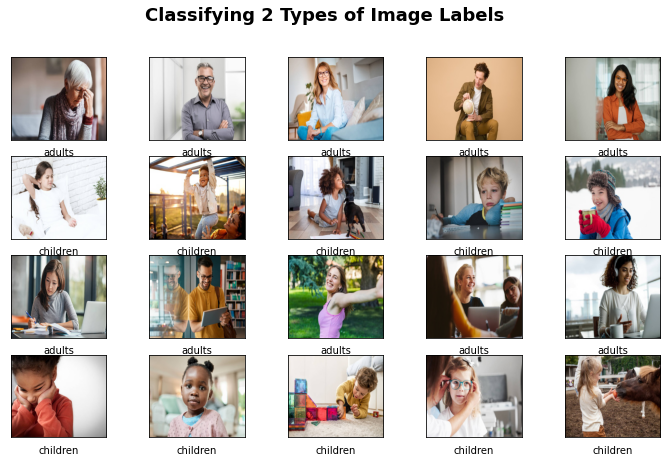

In [4]:
plt.figure(figsize=(12,7))
for i in range(len(vis_labels)):
    plt.subplot(4,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = mpimg.imread(vis_images[i])
    plt.imshow(img)
    plt.xlabel(vis_labels[i])
    plt.suptitle(f"Classifying 2 Types of Image Labels",fontsize=18, fontweight='bold')
plt.show()

# <b>4.0 <span style='color:red'>|</span> Show Augmented Images, That Can Reduce Overfitting </b> <a class="anchor" id="4.0"></a>

One excellent option to increase the amount of your dataset is to use the picture augmentation technique. You can use your original dataset to create new converted photos. However, a lot of users modify photographs in a conservative manner, by adding text and putting the results in a folder or a numpy array. I must admit that before discovering the ImageDataGenerator class, I used to do this. Now let’s dive deeper and check out the different ways in which this class is so great for image augmentation.

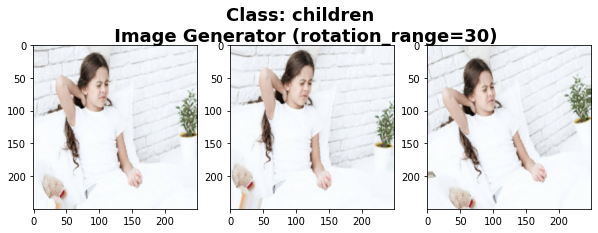

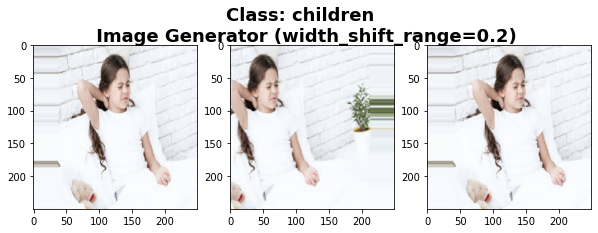

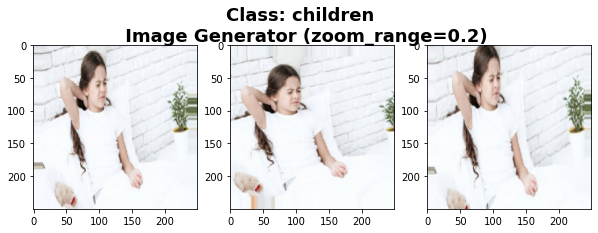

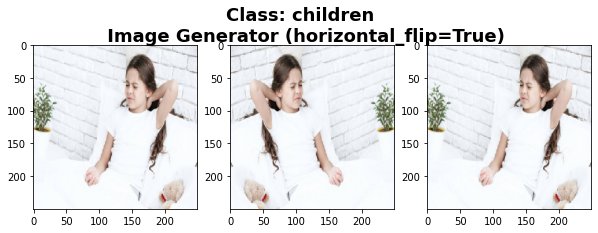

In [5]:
def show_ImageDataGenerator(vis_images, vis_labels, image_index):
    #Loads image in from the set image path
    class_label = vis_labels[image_index]
    img = tf.keras.preprocessing.image.load_img(vis_images[image_index], target_size= (250,250))
    img_tensor = tf.keras.preprocessing.image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)

    #Creates our batch of one image
    def show_image(datagen, param):
        pic = datagen.flow(img_tensor, batch_size =1)
        plt.figure(figsize=(10,3.5))
        #Plots our figures
        for i in range(1,4):
            plt.subplot(1, 3, i)
            batch = pic.next()
            image_ = batch[0].astype('uint8')
            plt.imshow(image_)
        plt.suptitle(f"Class: {class_label} \n Image Generator ({param})",fontsize=18, fontweight='bold')

        plt.show()

    datagen = ImageDataGenerator(rotation_range=30)
    show_image(datagen, "rotation_range=30")

    datagen = ImageDataGenerator(width_shift_range=0.2)
    show_image(datagen, "width_shift_range=0.2")

    datagen = ImageDataGenerator(zoom_range=0.2)
    show_image(datagen, "zoom_range=0.2")

    datagen = ImageDataGenerator(horizontal_flip=True)
    show_image(datagen, "horizontal_flip=True")

show_ImageDataGenerator(vis_images, vis_labels, image_index = 5)


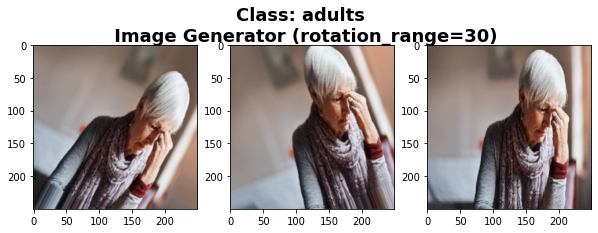

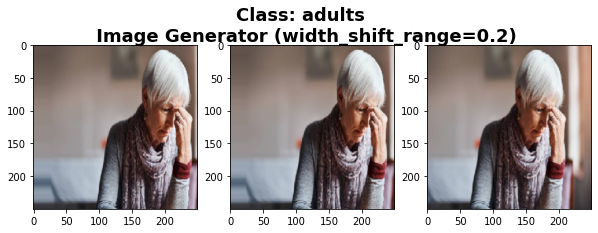

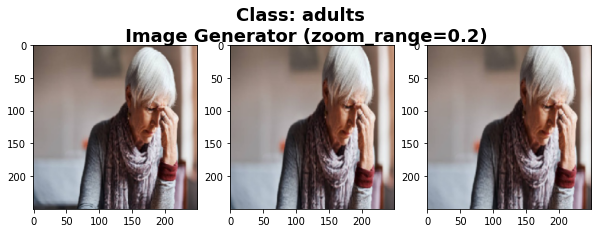

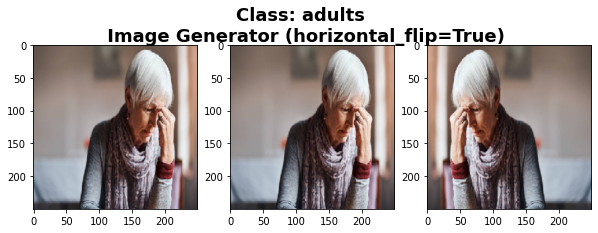

In [6]:
show_ImageDataGenerator(vis_images, vis_labels, image_index = 0)

# <b>5.0 <span style='color:red'>|</span> Get Augmented Images using Image Data Generator </b> <a class="anchor" id="5.0"></a>

A quick and simple approach to enhance your photographs is with the Keras ImageDataGenerator class. It offers a variety of augmentation methods, including standardisation, rotation, shifts, flips, brightness changes, and many others. Let's augment all our image now.

In [7]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

    # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
    train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=30,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

    # Pass in the appropriate arguments to the flow_from_directory method
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='binary',
                                                      target_size=(150, 150))

    # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
    validation_datagen = ImageDataGenerator(rescale=1./255)

    # Pass in the appropriate arguments to the flow_from_directory method
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32,
                                                                class_mode='binary',
                                                                target_size=(150, 150))
    return train_generator, validation_generator

In [8]:
training_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')
print(validation_dir)

/kaggle/input/children-vs-adults-images/test


The output below show the Image Data Generator successfully captured the data, and will transform it on the fly during training. So it will not generate new images that consume your memory

In [9]:
train_generator, validation_generator = train_val_generators(training_dir, validation_dir)

Found 680 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


# <b>6.0 <span style='color:red'>|</span> Get Transfer Learning Model - MobileNetV2 </b> <a class="anchor" id="6.0"></a>

MobileNetV2 is a very effective feature extractor for object detection and segmentation. [1,2]

In [10]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(150, 150, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
last_output = base_model.output
num_trainable_params = sum([w.shape.num_elements() for w in base_model.trainable_weights])

print(f"There are {num_trainable_params:,} trainable parameters in this model.")
print(f"The pretrained model has type: {type(base_model)}")

2022-09-23 15:32:57.015086: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


9420800/9406464 [==============================] - 0s 0us/step
There are 0 trainable parameters in this model.
The pretrained model has type: <class 'keras.engine.functional.Functional'>


# <b>7.0 <span style='color:red'>|</span> Building Deep Neural Network Architecture with MobileNetV2 </b> <a class="anchor" id="7.0"></a>

In [11]:
def transfer_learning(last_output, pre_trained_model):
    # Flatten the output layer to 1 dimension
    x = tf.keras.layers.Flatten()(last_output)
    # Add a fully connected layer with 1024 hidden units and ReLU activation
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    # Add a dropout rate of 0.6
    x = tf.keras.layers.Dropout(0.6)(x)  
    # Add a final sigmoid layer for classification
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)          
    # Create the complete model by using the Model class
    model = Model(inputs=pre_trained_model.input, outputs=x)
    
    return model

model = transfer_learning(last_output, base_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 75, 75, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 75, 75, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 75, 75, 32)   0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

# <b>8.0 <span style='color:red'>|</span> Tune Learning Rate </b> <a class="anchor" id="8.0"></a>

In [12]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

In [13]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
            loss = 'binary_crossentropy',
            metrics=['accuracy'])

The process below accuracy will not be converged, don't worry, this is because each epoch learning rate is different, in order to find out which learning rate is the best.

In [14]:
lr_history = model.fit(train_generator,
                       epochs=60,
                       validation_data=validation_generator,
                       callbacks=lr_schedule,
                       verbose=0)

2022-09-23 15:33:00.524123: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


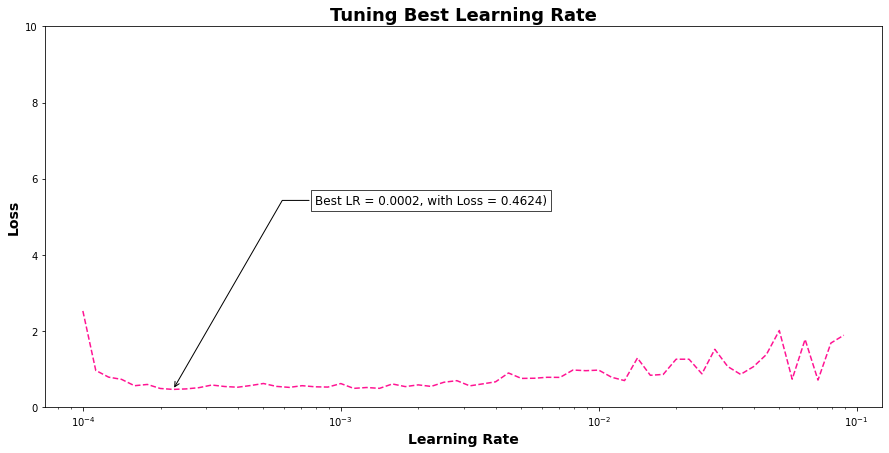

best learn rate = 0.00022387212084140629


In [15]:
def plot_best_learning(lr_history):
    x = lr_history.history["lr"] ; y = lr_history.history["loss"]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
    def annot_min(x,y, ax=None):
        xmin = x[np.argmin(y)]
        ymin = np.min(y)
        text= f"Best LR = {xmin:.4f}, with Loss = {ymin:.4f})"
        if not ax:
            ax=plt.gca()
        bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
        arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
        kw = dict(xycoords='data',textcoords="axes fraction",
                  arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
        ax.annotate(text, xy=(xmin, ymin), xytext=(0.6,0.56), fontsize=12, **kw)
        return xmin
    xmin = annot_min(x,y,ax)
    ax.semilogx(x, y,ls='dashed', color='deeppink')
    ax.set_title('Tuning Best Learning Rate',fontsize=18, fontweight='bold')
    ax.set_ylabel('Loss',fontsize=14, fontweight='bold')
    ax.set_xlabel('Learning Rate',fontsize=14, fontweight='bold')
    plt.ylim((0, 10))
    plt.show()
    return xmin
    

best_learn_rate = plot_best_learning(lr_history)
print(f"best learn rate = {best_learn_rate}")

# <b>9.0 <span style='color:red'>|</span> Training Model with Calibrated Learning Rate </b> <a class="anchor" id="9.0"></a>

In [16]:
model = transfer_learning(last_output, base_model)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = best_learn_rate),
            loss = 'binary_crossentropy',
            metrics=['accuracy'])

In [17]:
# Define a Callback class that stops training once accuracy reaches 95%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.95):
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True
callbacks = myCallback()

history = model.fit(train_generator,
                    epochs=20,
                    validation_data=validation_generator,
                    callbacks=callbacks)

Epoch 1/20
22/22 [==============================] - 16s 572ms/step - loss: 2.7218 - accuracy: 0.6529 - val_loss: 1.4203 - val_accuracy: 0.7417
Epoch 2/20
22/22 [==============================] - 12s 543ms/step - loss: 1.6260 - accuracy: 0.7206 - val_loss: 1.1094 - val_accuracy: 0.7500
Epoch 3/20
22/22 [==============================] - 12s 523ms/step - loss: 1.2456 - accuracy: 0.7485 - val_loss: 0.8885 - val_accuracy: 0.7833
Epoch 4/20
22/22 [==============================] - 12s 518ms/step - loss: 0.7213 - accuracy: 0.7676 - val_loss: 0.6536 - val_accuracy: 0.7667
Epoch 5/20
22/22 [==============================] - 12s 525ms/step - loss: 0.6600 - accuracy: 0.7500 - val_loss: 0.5930 - val_accuracy: 0.7500
Epoch 6/20
22/22 [==============================] - 12s 520ms/step - loss: 0.4806 - accuracy: 0.7691 - val_loss: 0.4660 - val_accuracy: 0.7833
Epoch 7/20
22/22 [==============================] - 12s 545ms/step - loss: 0.4248 - accuracy: 0.8279 - val_loss: 0.5193 - val_accuracy: 0.7667

# <b>10.0 <span style='color:red'>|</span> Visualise Model Performance </b> <a class="anchor" id="10.0"></a>

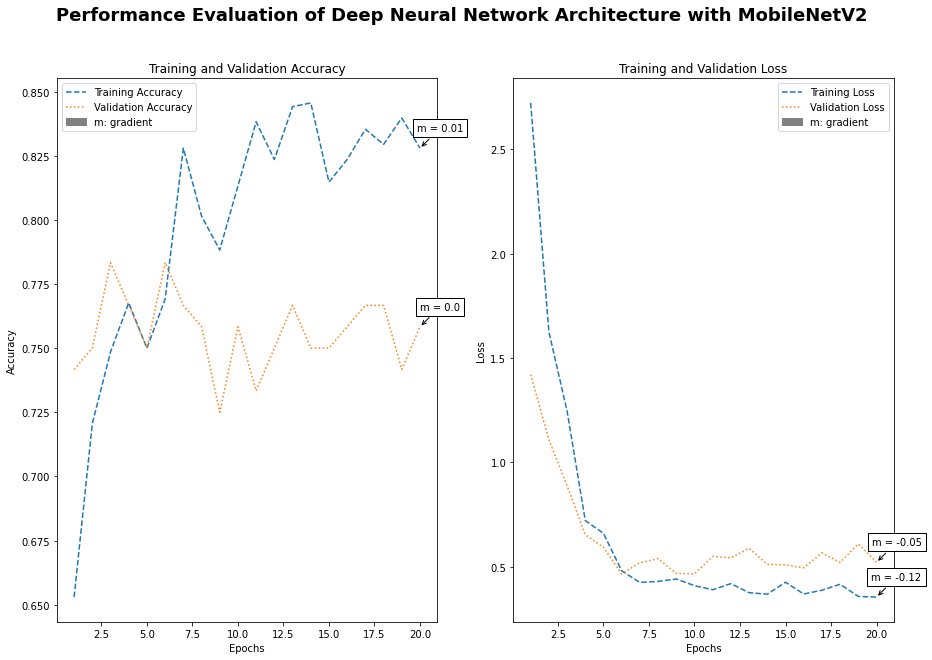

In [18]:
def vis_evaluation(history_dict, model_name):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
    epochs = range(1, len(history_dict['accuracy'])+1)

    def get_gradient(y_arr, epochs):
        return round((y_arr[-1] - y_arr[0]) / (epochs[-1] - epochs[0]),2)

    def vis_sub_evaluation(n, Accuracy, train_acc, val_acc, epochs):
        axs[n].plot(epochs, train_acc, label=f'Training {Accuracy}', ls='--')
        axs[n].plot(epochs, val_acc, label=f'Validation {Accuracy}', ls='dotted')

        axs[n].set_title(f'Training and Validation {Accuracy}')
        axs[n].set_xlabel('Epochs')
        axs[n].set_ylabel(Accuracy)
        
        handles, labels = axs[n].get_legend_handles_labels()
        m_patch = mpatches.Patch(color='grey',label='m: gradient')
        handles.append(m_patch) 
        axs[n].legend(handles=handles)
        
        def annotate_box(train_acc):
            return AnnotationBbox(TextArea(f"m = {get_gradient(train_acc, epochs)}"), (epochs[-1], train_acc[-1]),
                            xybox=(20, 20),
                            xycoords='data',
                            boxcoords="offset points",
                            arrowprops=dict(arrowstyle="->"))
        axs[n].add_artist(annotate_box(train_acc))
        axs[n].add_artist(annotate_box(val_acc))

    train_acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    vis_sub_evaluation(0, 'Accuracy', train_acc, val_acc, epochs)

    train_loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    vis_sub_evaluation(1, 'Loss', train_loss, val_loss, epochs)
    
    plt.suptitle(f"Performance Evaluation of {model_name}",fontsize=18, fontweight='bold')
    plt.show()
    
history_dict = history.history
vis_evaluation(history_dict, 'Deep Neural Network Architecture with MobileNetV2')

In [19]:
vis_images[:5]

['/kaggle/input/children-vs-adults-images/test/adults/45.jpg',
 '/kaggle/input/children-vs-adults-images/test/adults/56.jpg',
 '/kaggle/input/children-vs-adults-images/test/adults/20.jpg',
 '/kaggle/input/children-vs-adults-images/test/adults/58.jpg',
 '/kaggle/input/children-vs-adults-images/test/adults/6.jpg']

In [20]:
vis_images[5:10]

['/kaggle/input/children-vs-adults-images/test/children/45.jpg',
 '/kaggle/input/children-vs-adults-images/test/children/56.jpg',
 '/kaggle/input/children-vs-adults-images/test/children/20.jpg',
 '/kaggle/input/children-vs-adults-images/test/children/58.jpg',
 '/kaggle/input/children-vs-adults-images/test/children/6.jpg']

# <b>11.0 <span style='color:red'>|</span> What Computer see during training convolutional images </b> <a class="anchor" id="11.0"></a>

Visualizing how an input is modified as it passes through the model is a great way to get a sense of the features your deep CNN with MobileNetV2 has learned.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


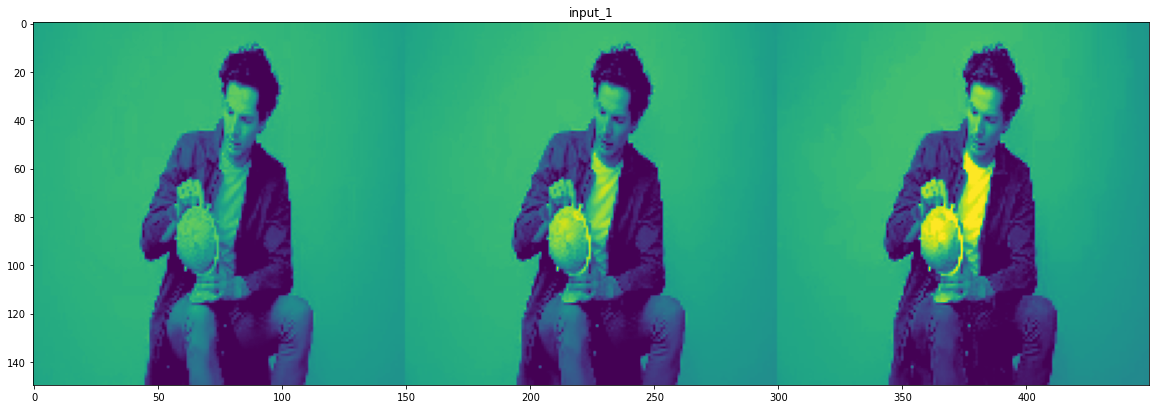

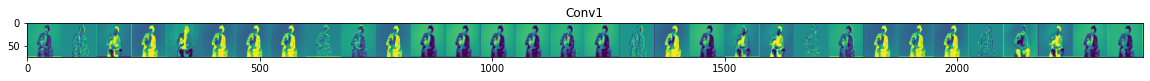

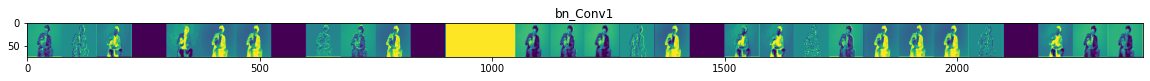

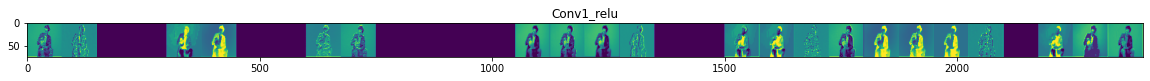

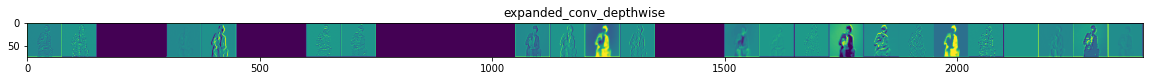

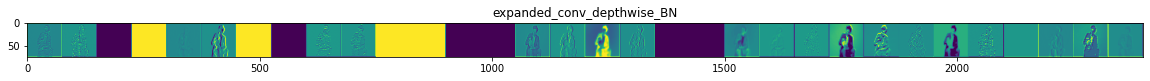

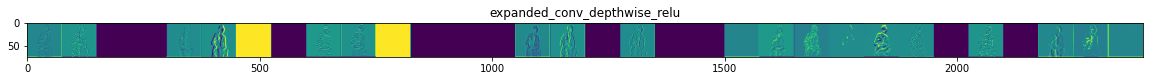

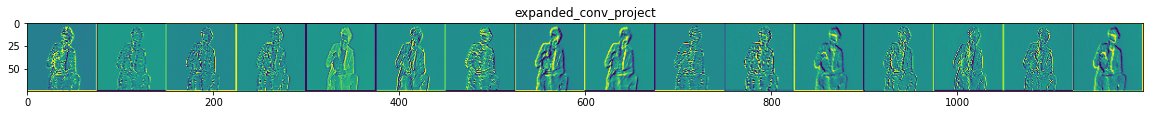

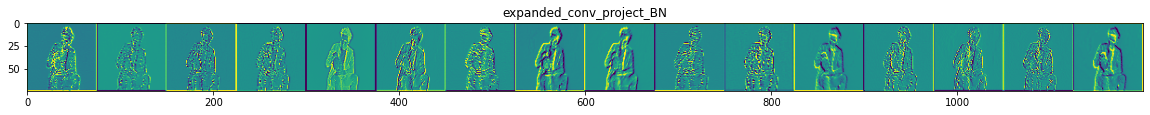

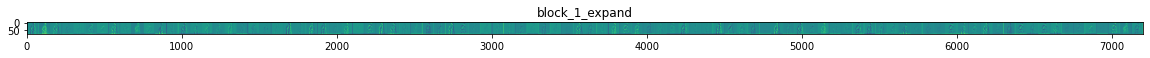

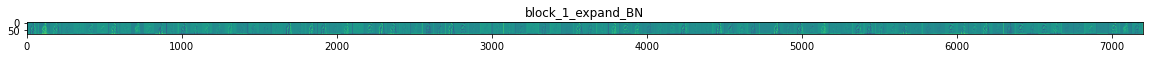

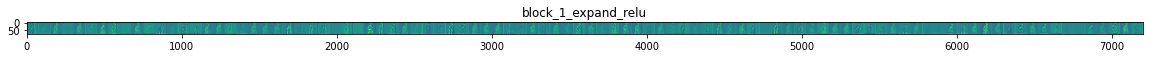

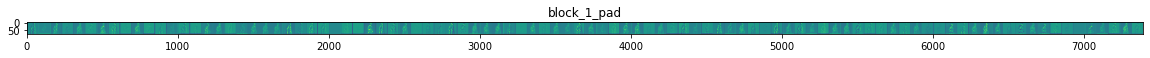

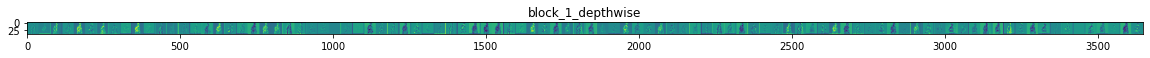

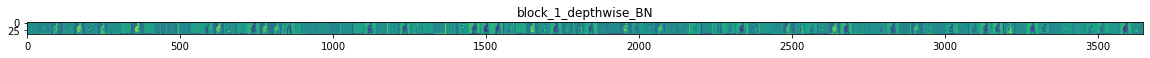

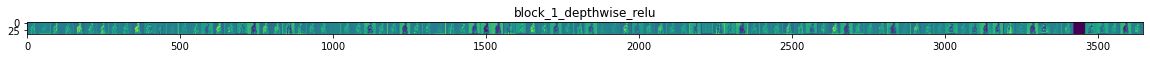

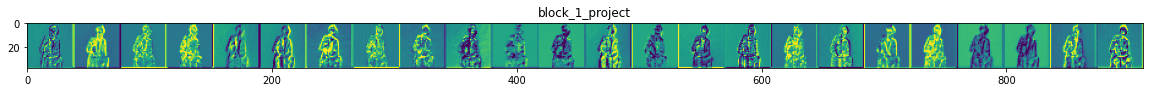

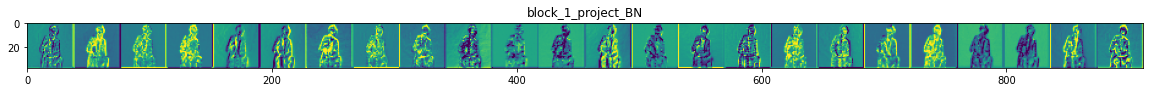

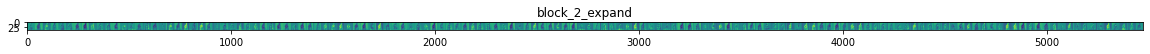

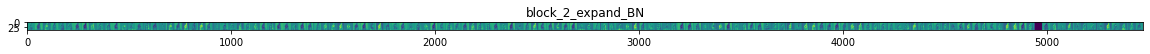

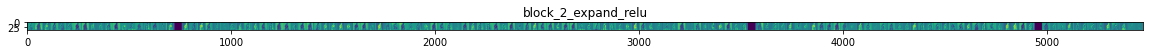

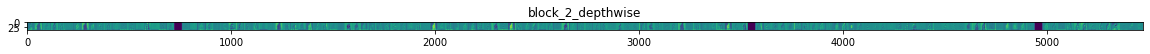

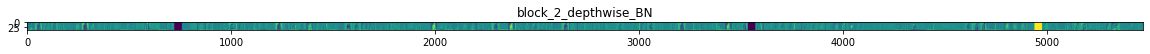

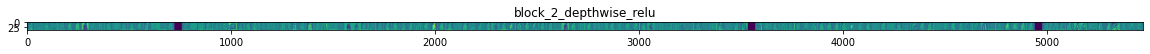

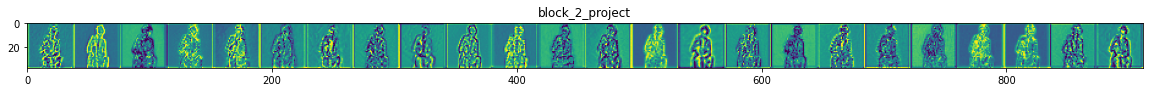

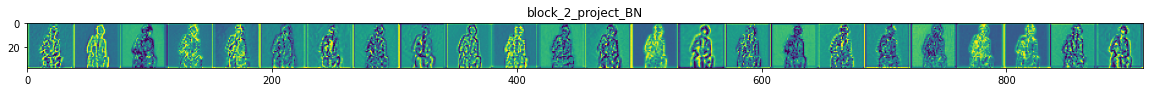

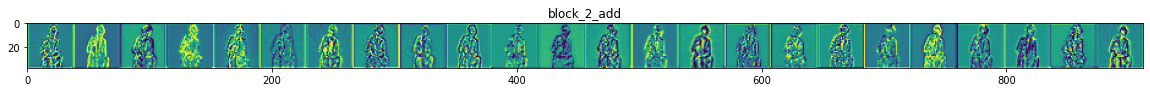

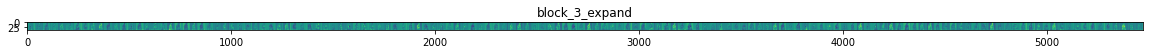

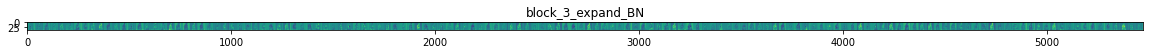

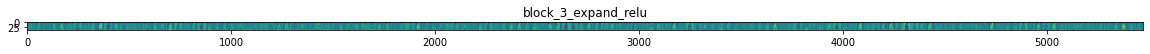

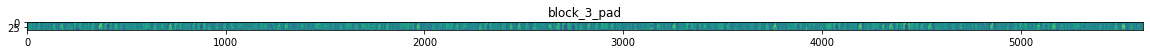

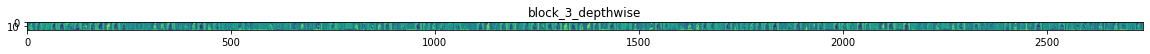

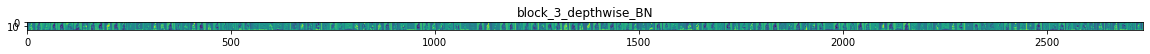

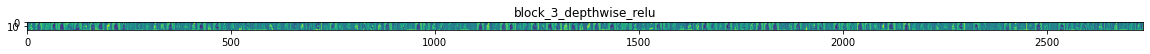

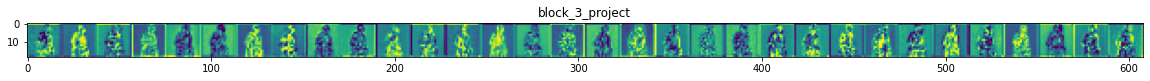

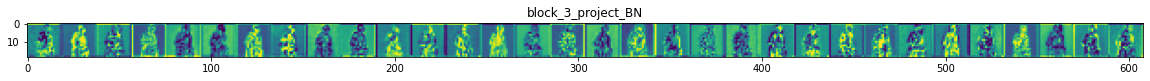

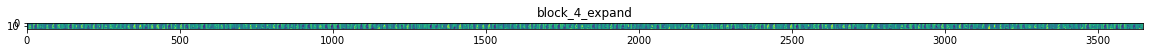

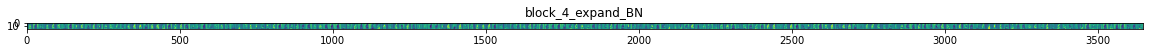

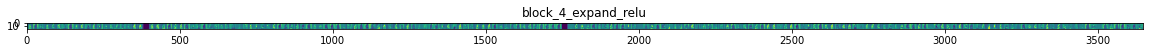

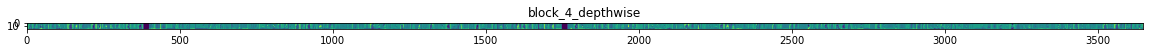

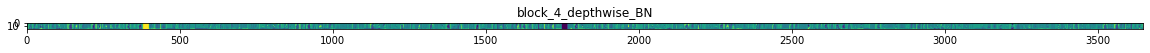

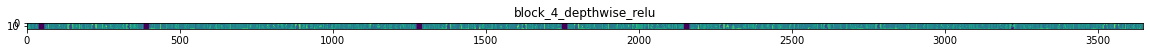

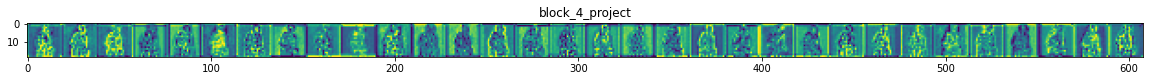

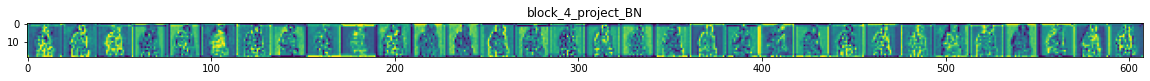

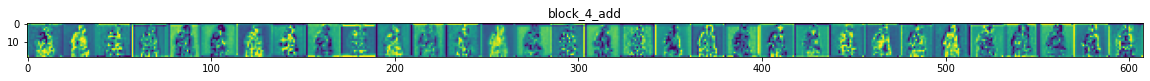

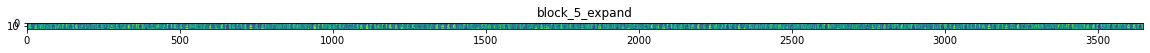

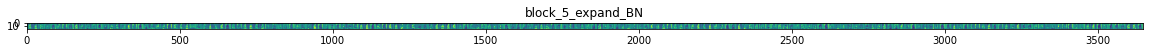

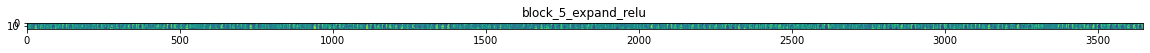

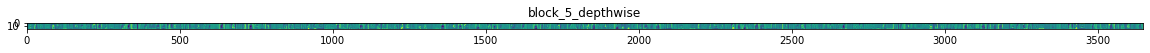

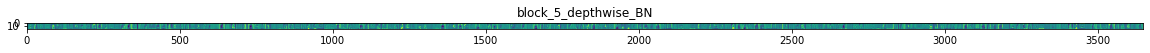

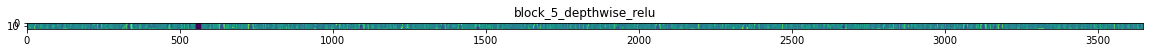

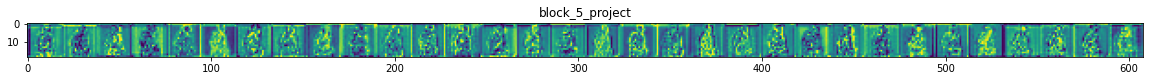

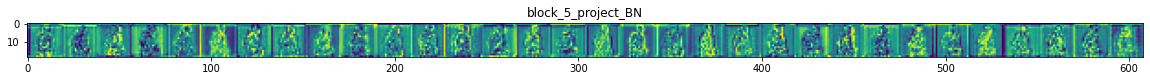

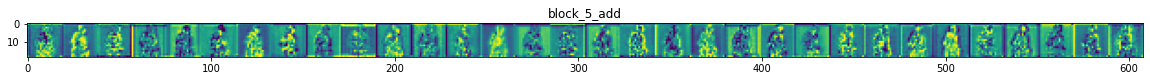

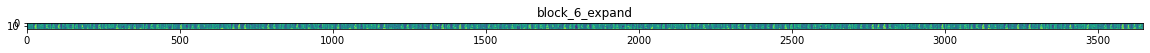

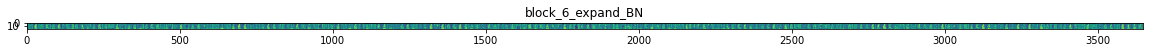

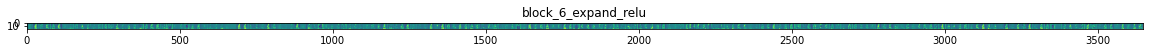

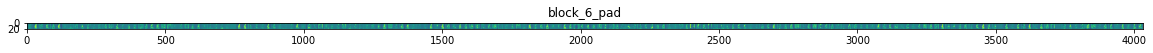

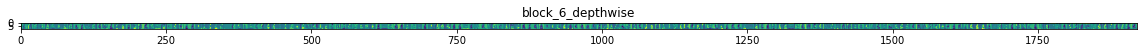

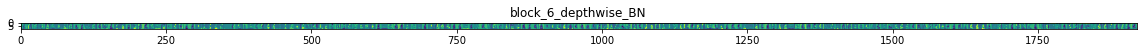

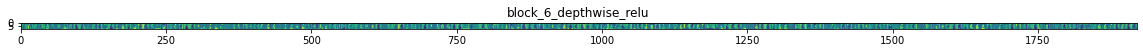

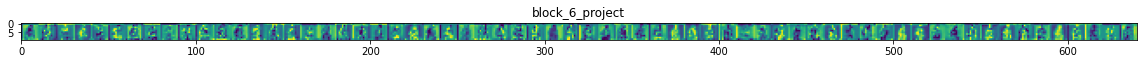

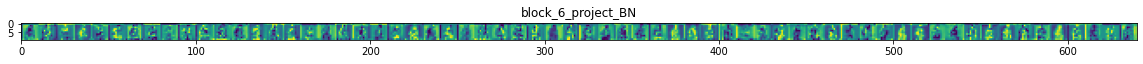

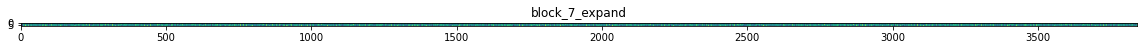

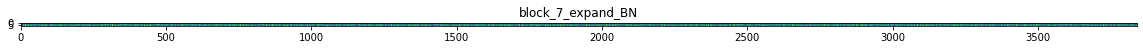

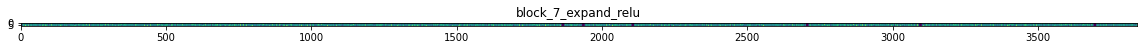

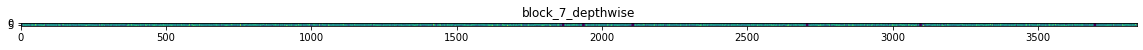

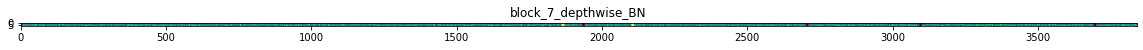

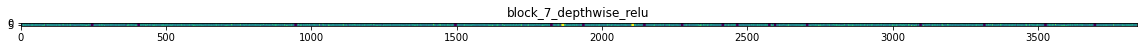

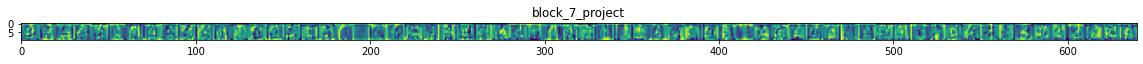

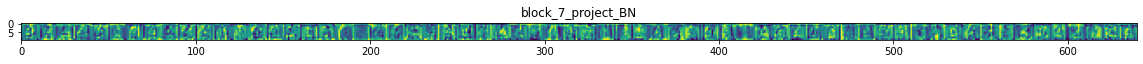

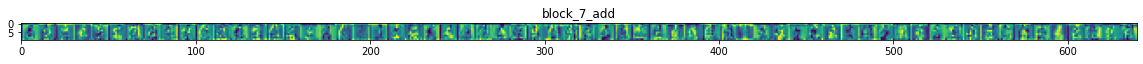

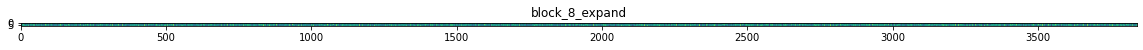

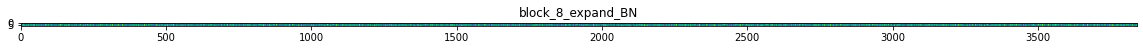

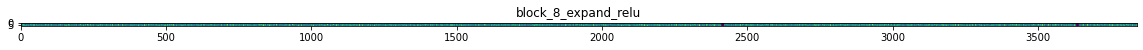

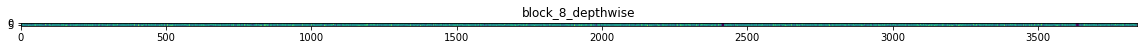

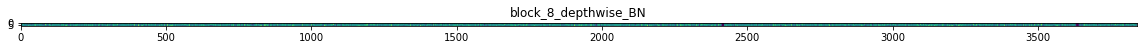

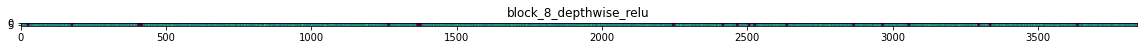

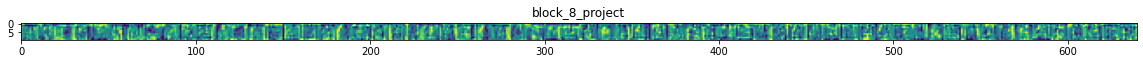

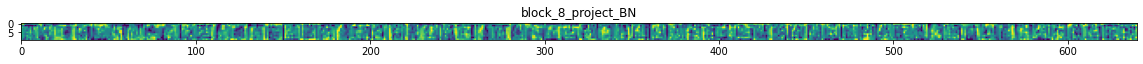

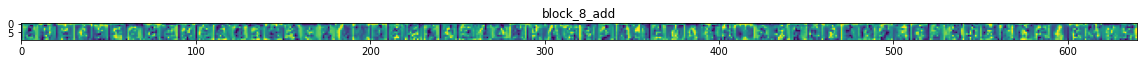

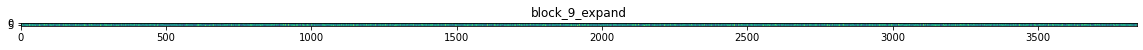

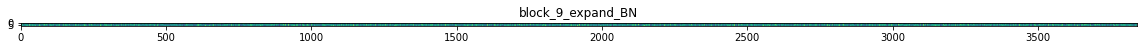

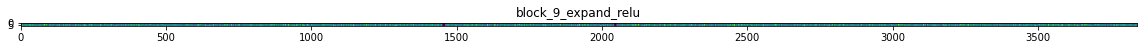

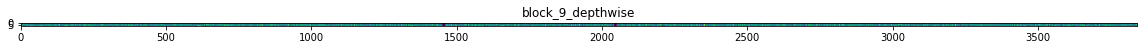

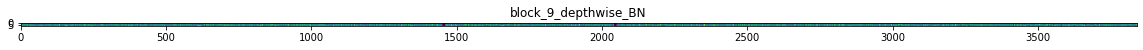

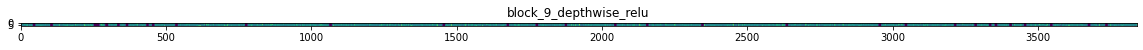

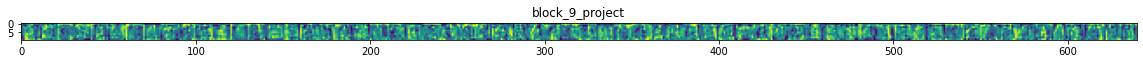

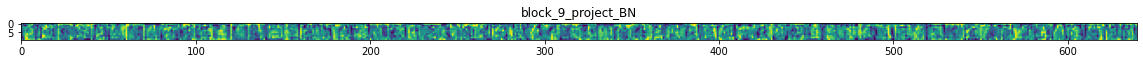

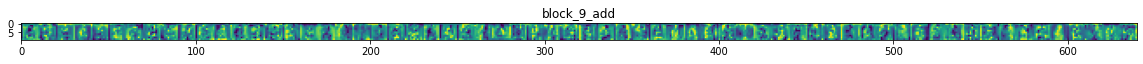

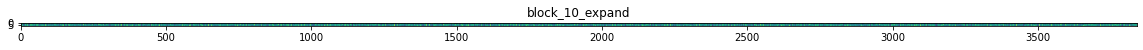

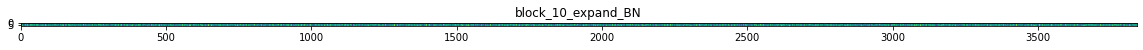

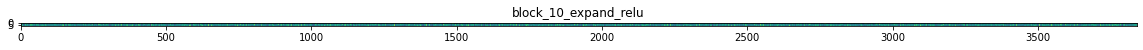

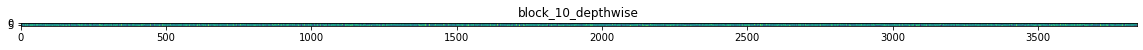

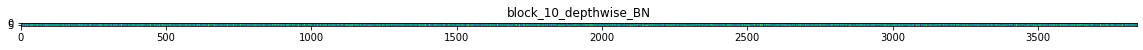

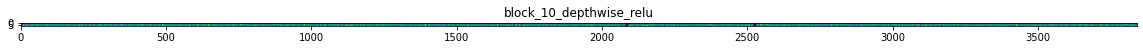

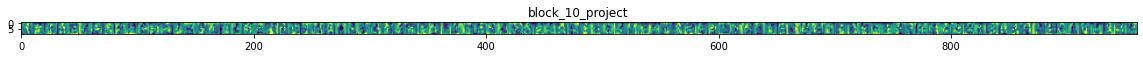

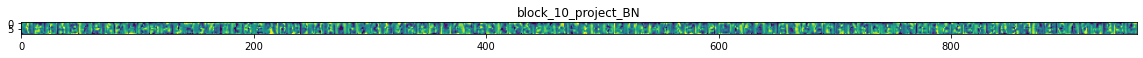

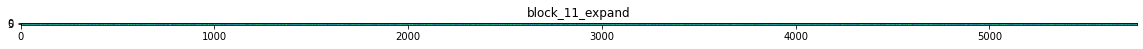

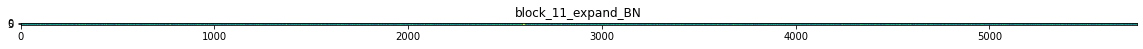

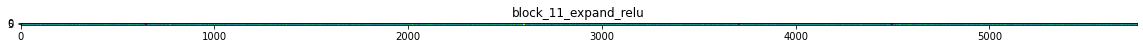

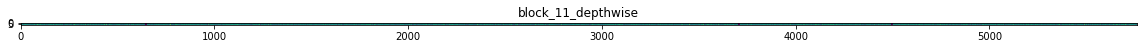

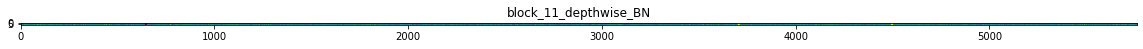

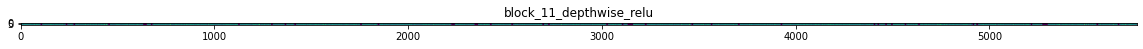

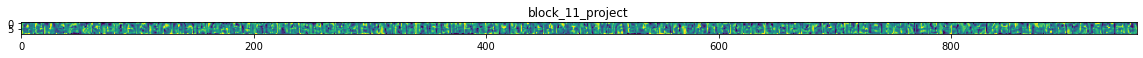

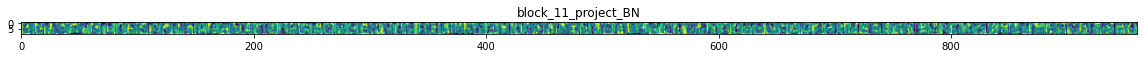

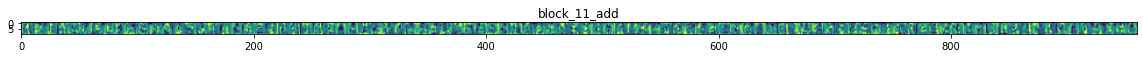

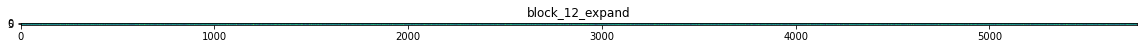

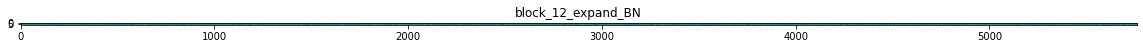

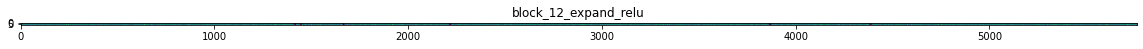

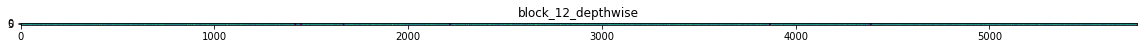

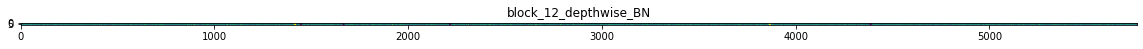

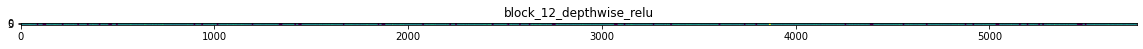

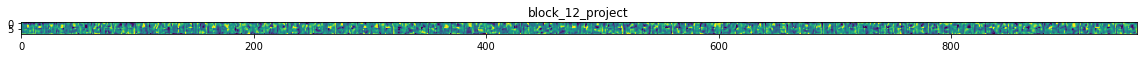

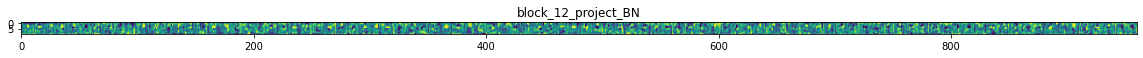

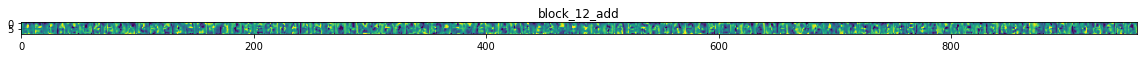

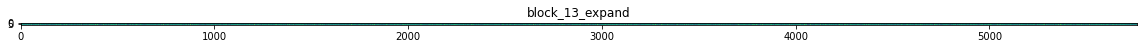

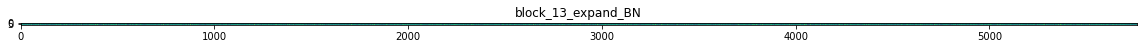

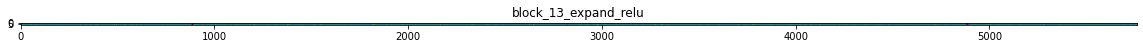

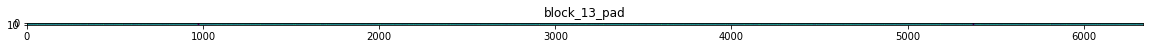

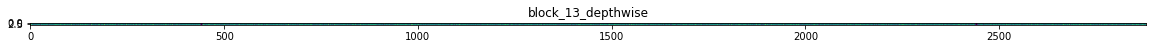

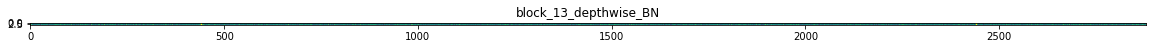

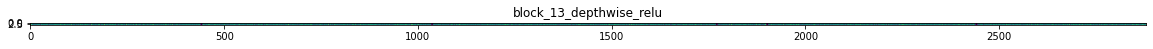

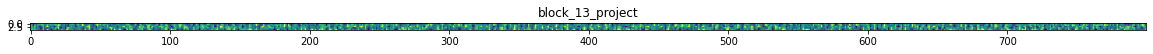

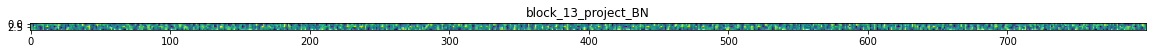

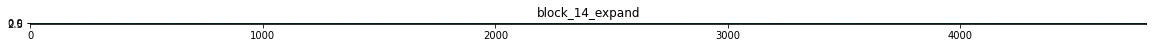

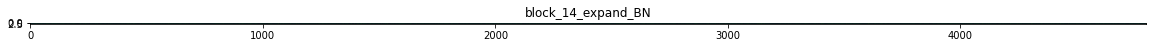

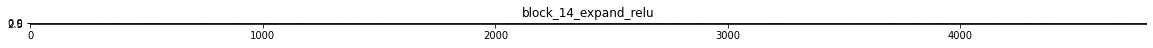

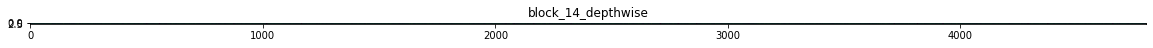

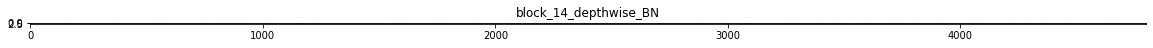

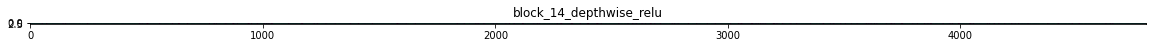

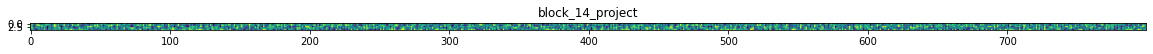

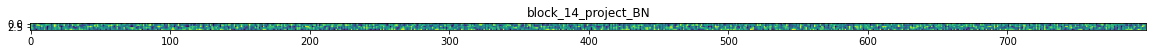

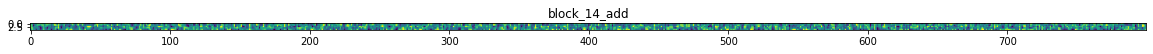

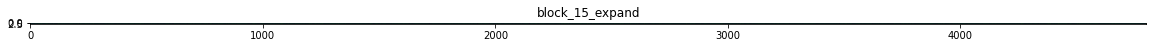

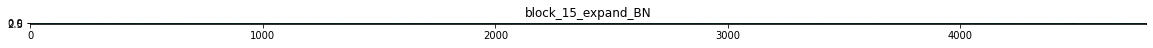

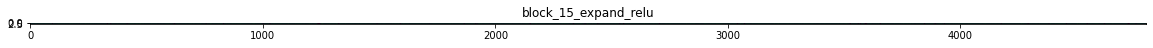

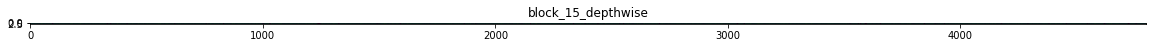

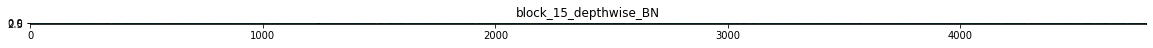

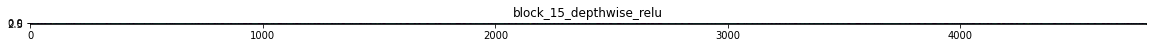

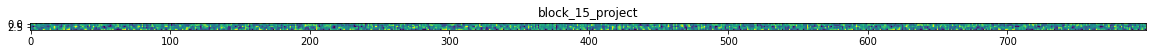

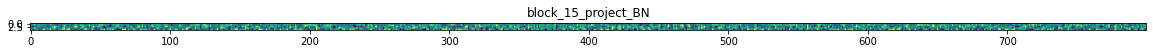

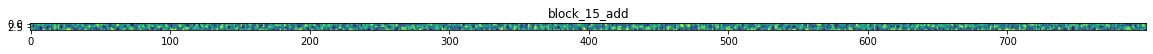

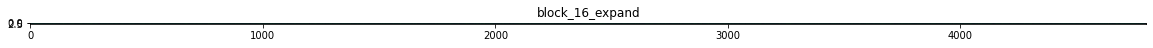

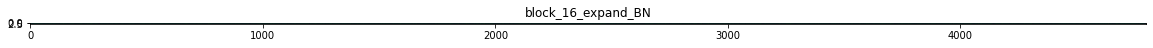

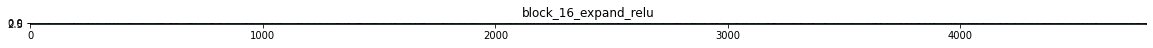

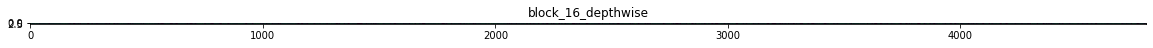

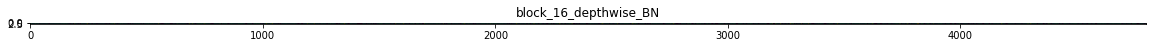

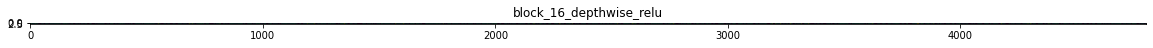

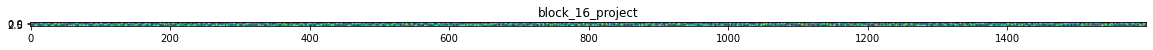

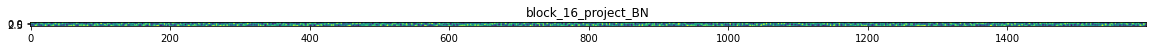

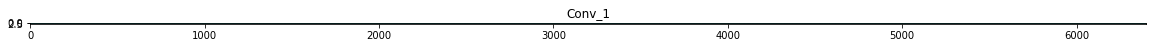

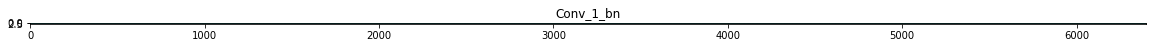

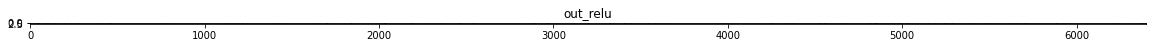

In [21]:
# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model
successive_outputs = [layer.output for layer in model.layers]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Prepare a random input image from the training set.
adult_img_files = vis_images[:5]
child_img_files = vis_images[5:10]
img_path = random.choice(adult_img_files + child_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Scale by 1/255
x /= 255.0

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so you can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # Tile the images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
        x  = feature_map[0, :, :, i]
        x -= x.mean()
        x /= x.std ()
        x *=  64
        x += 128
        x  = np.clip(x, 0, 255).astype('uint8')
        display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

# <b>12.0 <span style='color:red'>|</span> Test Your Own Images </b> <a class="anchor" id="12.0"></a>

At the end, let's enjoy the AI prediction. If you like this notebook, pelase upvote ^^

 This image most likely belongs to 'children' with a 71.82 percent confidence.


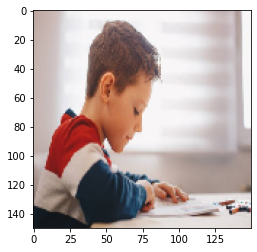

In [22]:
def make_your_prediction(YOUR_IMAGE_PATH = None):
    if YOUR_IMAGE_PATH == None:
        YOUR_IMAGE_PATH = '/kaggle/input/children-vs-adults-images/test/children/0.jpg' 
    
    img = image.load_img(YOUR_IMAGE_PATH, target_size=(150, 150))
    plt.imshow(img)
    x = image.img_to_array(img)
    x /= 255
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    score = tf.nn.sigmoid(classes[0])

    class_name = train_generator.class_indices
    class_name_inverted = {y: x for x, y in class_name.items()}

    if classes[0]>0.5:
        print(f" This image most likely belongs to '{class_name_inverted[1]}' with a {100 * np.max(score):.2f} percent confidence.")
    else:
        print(f" This image most likely belongs to '{class_name_inverted[0]}' with a {100 * np.max(score):.2f} percent confidence.")

make_your_prediction(YOUR_IMAGE_PATH = None)

Author: [Morris Lee](http://www.morris-lee.com/) (22/9/2022)


# References

[1] ImageNet. http://www.image-net.org

[2] Sandler, M., Howard, A., Zhu, M., Zhmoginov, A. and Chen, L.C. "MobileNetV2: Inverted Residuals and Linear Bottlenecks." In 2018 IEEE/CVF Conference on Computer Vision and Pattern Recognition (pp. 4510-4520). IEEE.

<div style="display:fill;
            border-radius:12px;
            background-color:lightblue;
            font-size:150%;
            letter-spacing:0.5px;
            padding:10px;
            color:black;
            border-style: solid;
            border-color: darkblue;
            border-width: thick;
            text-align:center;">
<b>
 The end. If you find this notebook useful, please upvote or let me know ^^ </b></div>